## Final Notebook

Please fill out:
* Student name: Andrew Levinton
* Student pace: self paced 
* Scheduled project review date/time: 
* Instructor name: Ahbineet Kulkarni
* Blog post URL:


## Statsmodels debug
- This is because statsmodels was having version issues. this is a workaround
- The code below re-publishes the existing (but private) _centered function as a public attribute to the module already imported in RAM.

In [293]:
import  scipy.signal.signaltools

def _centered(arr, newsize):
    # Return the center newsize portion of the array.
    newsize = np.asarray(newsize)
    currsize = np.array(arr.shape)
    startind = (currsize - newsize) // 2
    endind = startind + newsize
    myslice = [slice(startind[k], endind[k]) for k in range(len(endind))]
    return arr[tuple(myslice)]

scipy.signal.signaltools._centered = _centered

## Import necessary libraries

In [294]:
# raw data handling
import pandas as pd
import numpy as np
import datetime as dt

# data visualiztion
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

# regression modeling
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import variance_inflation_factor


# model validation
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error

import warnings # weird sns.distplot() warnings
warnings.filterwarnings("ignore")



plt.style.use('ggplot')

## Define Functions

In [295]:

# Grabbing vifs

def get_vifs(data):
    # Get a list of the column names
    cols = data.columns

    # Create an empty DataFrame to hold the VIF results
    vif_data = pd.DataFrame()

    # Loop through each column and calculate the VIF
    for i in range(len(cols)):
        vif = variance_inflation_factor(data[cols].values, i)
        vif_data = vif_data.append({'Variable': cols[i], 'VIF': vif}, ignore_index=True)

    # Print the VIF results
    return print(vif_data)


# get ols model and plot residual distribution
def get_OLS_model(name, X, y):
    model = sm.OLS(y, sm.add_constant(X))
    results = model.fit()
    model_residual = results.resid
    
    return print(results.summary()), plt.suptitle(f'Residual distribution for {name} model'), sns.distplot(model_residual), plt.show()



#get qq and histogram plots 
def plot_hist_qq(df, target_col):
    """
    Creates a histogram and QQ-plot for a given dataframe and target column.

    Args:
        df (pandas.DataFrame): The dataframe to plot.
        target_col (str): The name of the target column.

    Returns:
        None
    """
    # Create subplots with 1 row and 2 columns
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    # Plot histogram on the first subplot
    axs[0].hist(df[target_col], bins=30)
    axs[0].set_xlabel(target_col)
    axs[0].set_ylabel('Frequency')

    # Plot QQ-plot on the second subplot
    stats.probplot(df[target_col], plot=axs[1])
    axs[1].set_xlabel('Theoretical quantiles')
    axs[1].set_ylabel('Sample quantiles')

    # Adjust the layout and display the plot
    plt.tight_layout()
    plt.show()
    
# getting qqplots from stats model
def get_model_qqplots(data, y):    
    # Set up the plot grid
    fig, axes = plt.subplots(nrows=4, ncols=6, figsize=(25, 18))

    # Loop through each variable in the DataFrame
    for i, var in enumerate(data.columns):
        # Fit a linear regression model
        X = sm.add_constant(data[var])
        model = sm.OLS(y, X).fit()

        # Calculate the residuals
        resid = model.resid

        # Create a QQ plot
        sm.qqplot(resid, line='s', ax=axes[i//6, i%6])
        axes[i//6, i%6].set_title(var)

    plt.tight_layout()
    plt.show()

## Read in dataset, check length

In [296]:
cd data

[WinError 2] The system cannot find the file specified: 'data'
C:\Users\alevi\Documents\Flatiron\dsc-data-science-env-config\Course_Folder\Phase_2\Housing_Linear_Model_Project\data


In [297]:
df = pd.read_csv('kc_house_data.csv')
len(df)

30155

## Dataset timeline

In [298]:
df['yr_built'].min(), df['yr_built'].max()

(1900, 2022)

### Checking dtypes

In [299]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30155 entries, 0 to 30154
Data columns (total 25 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             30155 non-null  int64  
 1   date           30155 non-null  object 
 2   price          30155 non-null  float64
 3   bedrooms       30155 non-null  int64  
 4   bathrooms      30155 non-null  float64
 5   sqft_living    30155 non-null  int64  
 6   sqft_lot       30155 non-null  int64  
 7   floors         30155 non-null  float64
 8   waterfront     30155 non-null  object 
 9   greenbelt      30155 non-null  object 
 10  nuisance       30155 non-null  object 
 11  view           30155 non-null  object 
 12  condition      30155 non-null  object 
 13  grade          30155 non-null  object 
 14  heat_source    30123 non-null  object 
 15  sewer_system   30141 non-null  object 
 16  sqft_above     30155 non-null  int64  
 17  sqft_basement  30155 non-null  int64  
 18  sqft_g

## Linear Model must meet the following assumptions:

### Simple Linear Regression on select features
Assumption check:
- Is it linear?
- Is it normal?
    - histogram
    - QQ-plot
- Is it homoscedastic?

## The process for building this linear model:
- Prep data for linear model regression: This involves dropping null values, dropping "bad data", as well as engineering features to assist in assuming linearization
- Key scores to look at:
- `R-Squared ( or the coefficient of determination)` - a statistical measure in a regression model that determines the proportion of variance in the dependent variable that can be explained by the independent variable. In other words, r-squared shows how well the data fit the regression model (the goodness of fit).
- `Correlation coefficients` - check to see what variables seem relatable to the target variable (price)
- `residual plots` - check how far data compares to the mean. Data should be normally distributed to avoid skewness of the mean
- `variance inflation factor` - level of statistical skew
- `Root mean squared erro`r - how far predictions fall from measured true values using Euclidean distance.
- `pvalues of independent variables` - measures how statistically significant the independent variables are

## Data Preparation

## Dropping nullls

In [300]:
df.dropna(inplace=True)

### Recheck length

In [301]:
len(df)

30111

### Looking at Washington state

In [302]:
df['address'] = df['address'].str.lower()

In [303]:
df = df[df['address'].str.contains('washington')]

In [304]:
len(df)

29208

## Grabbing Zipcodes

In [305]:
df['zipcode'] = df['address'].apply(lambda x: x.split(',')[2].split(' ')[-1])

In [306]:
df['zipcode'] = df['zipcode'].astype(str)

In [307]:
df['zipcode'].unique()

array(['98055', '98133', '98178', '98118', '98027', '98166', '98030',
       '98023', '98019', '98144', '98031', '98092', '98103', '98006',
       '98136', '98007', '98038', '98057', '98077', '98126', '98053',
       '98039', '98107', '98008', '98155', '98168', '98199', '98004',
       '98045', '98052', '98011', '98002', '98033', '98116', '98198',
       '98125', '98001', '98112', '98034', '98056', '98059', '98005',
       '98040', '98014', '98106', '98029', '98122', '98003', '98117',
       '98042', '98119', '98065', '98022', '98072', '98058', '98108',
       '98115', '98074', '98105', '98024', '98146', '98109', '98102',
       '98028', '98188', '98177', '98075', '98010', '98148', '98047',
       '98032', '98070', '98051', '98288', '98354', '98272', '98296',
       '98271', '98050', '63090', 'seattle', '98387', '15301', '98251',
       '98223', '98338', '98224', '98372', '98663', '99202', '99403',
       '98422', '99203', '99223', '98270'], dtype=object)

## Categorizing waterfronts

In [308]:
duwamish = ['98168']
elliot_bay_zips= ['98119','98104','98129','98132','98127','98125','98195','98101','98134','98170','98139','98131','98181','98121'] 
puget_sound = ['98071','98083','98013','98070','98031','98131','98063','98195','98207','98190'] 
lake_union = ['98109']
ship_canal = ['00000'] 
lake_washington = ['98072','98077'] 
lake_sammamish = ['98074','98075','98029'] 
other = ['00000']
river_slough_waterfronts = ['00000']

df['waterfront_loc'] = df['zipcode'].apply(lambda x: 'Duwamish' if x=='98168'\
                                          else 'Elliot Bay' if x in elliot_bay_zips\
                                          else 'Puget Sound' if x in puget_sound\
                                          else 'Lake Union' if x in lake_union\
                                          else 'ship canal' if x in ship_canal\
                                          else 'Lake Washington' if x in lake_washington\
                                          else 'Lake Sammamish' if x in lake_sammamish\
                                          else 'other')

In [309]:
df['waterfront_loc'].value_counts()

other              25497
Lake Sammamish      1159
Elliot Bay           730
Puget Sound          721
Lake Washington      589
Duwamish             383
Lake Union           129
Name: waterfront_loc, dtype: int64

## Filter by state of Washington Zipcodes (assuming seattle is its own zipcode)

In [310]:
df = df[df['zipcode'].str.startswith('98') | df['zipcode'].str.contains('seattle')]

## One Hot Encoding Waterfronts

In [311]:
waterfront_dummies = pd.get_dummies(df['waterfront_loc'], prefix='water', drop_first=True)

In [312]:
waterfront_dummies

,water_Elliot Bay,water_Lake Sammamish,water_Lake Union,water_Lake Washington,water_Puget Sound,water_other
0,0,0,0,0,0,1
1,0,0,0,0,0,1
2,0,0,0,0,0,1
3,0,0,0,0,0,1
4,0,0,0,0,0,1
...,...,...,...,...,...,...
30150,0,0,0,0,0,1
30151,0,0,0,0,0,1
30152,0,0,0,0,0,1
30153,0,0,0,0,0,1


In [313]:
len(df) 

29200

In [314]:
len(df) == len(waterfront_dummies)

True

In [315]:
df = pd.concat([df,waterfront_dummies], axis=1)

## replacing seattle with seattle zipcode

In [316]:
df['zipcode'] = df['zipcode'].apply(lambda x: '98101' if x=='seattle' else x)

## recheck zipcodes

In [317]:
df['zipcode'].unique()

array(['98055', '98133', '98178', '98118', '98027', '98166', '98030',
       '98023', '98019', '98144', '98031', '98092', '98103', '98006',
       '98136', '98007', '98038', '98057', '98077', '98126', '98053',
       '98039', '98107', '98008', '98155', '98168', '98199', '98004',
       '98045', '98052', '98011', '98002', '98033', '98116', '98198',
       '98125', '98001', '98112', '98034', '98056', '98059', '98005',
       '98040', '98014', '98106', '98029', '98122', '98003', '98117',
       '98042', '98119', '98065', '98022', '98072', '98058', '98108',
       '98115', '98074', '98105', '98024', '98146', '98109', '98102',
       '98028', '98188', '98177', '98075', '98010', '98148', '98047',
       '98032', '98070', '98051', '98288', '98354', '98272', '98296',
       '98271', '98050', '98101', '98387', '98251', '98223', '98338',
       '98224', '98372', '98663', '98422', '98270'], dtype=object)

In [318]:
len(df['zipcode'].unique())

89

## Observing correlation matrix for possible features that can be used with the price

In [319]:
df.corr()['price'].abs().sort_values(ascending=False)

price                    1.000000
sqft_living              0.616741
sqft_above               0.546108
bathrooms                0.488039
sqft_patio               0.317623
lat                      0.296212
bedrooms                 0.290994
sqft_garage              0.267477
sqft_basement            0.246548
floors                   0.199285
water_Lake Sammamish     0.141426
yr_built                 0.105877
sqft_lot                 0.086790
yr_renovated             0.085506
long                     0.081940
water_Lake Washington    0.070383
water_Puget Sound        0.068457
water_other              0.064781
water_Lake Union         0.035352
id                       0.030237
water_Elliot Bay         0.004859
Name: price, dtype: float64

### Observations
- At first glance, it appears that sqft_living, sqft_above and bathrooms are the strongest correlated features to the price. 
- Further investigation is needed to measure the validity of the variables. They may be correlated with the price due to skewness or other factors that can make the correlation a deceptively "good" feature.

## Changing categorical variables to numerical columns - this needs to be done if we want to use them in a linear model

In [320]:
#extracting grade as an integer
df['grade'] = df['grade'].apply(lambda x: int(str(x.split(' ')[0])))

# replacing conditions with values
cond_dict = {'Poor':1,'Fair':2,'Average':3,'Good':4,'Very Good':5}
df.condition.replace(to_replace=cond_dict,inplace=True)

#changing date to datetime object, get day and month
df['date'] = pd.to_datetime(df['date'])
df['month'] = df['date'].dt.month

df['day_of_year'] = df['date'].dt.dayofyear

## Recheck dtypes

In [321]:
df.dtypes

id                                int64
date                     datetime64[ns]
price                           float64
bedrooms                          int64
bathrooms                       float64
sqft_living                       int64
sqft_lot                          int64
floors                          float64
waterfront                       object
greenbelt                        object
nuisance                         object
view                             object
condition                         int64
grade                             int64
heat_source                      object
sewer_system                     object
sqft_above                        int64
sqft_basement                     int64
sqft_garage                       int64
sqft_patio                        int64
yr_built                          int64
yr_renovated                      int64
address                          object
lat                             float64
long                            float64


### Extracting Numerical Predictors by filtering dtypes

In [322]:
df.dtypes.unique()

array([dtype('int64'), dtype('<M8[ns]'), dtype('float64'), dtype('O'),
       dtype('uint8')], dtype=object)

In [323]:
# categorizing dtypes
numerical_types = ['int64','float64']
numerical_predictors = list(df.select_dtypes(include=numerical_types))
numerical_predictors

['id',
 'price',
 'bedrooms',
 'bathrooms',
 'sqft_living',
 'sqft_lot',
 'floors',
 'condition',
 'grade',
 'sqft_above',
 'sqft_basement',
 'sqft_garage',
 'sqft_patio',
 'yr_built',
 'yr_renovated',
 'lat',
 'long',
 'month',
 'day_of_year']

### Create dataframe of numerical values

In [324]:
# df[numerical_predictors] selects only numerical columns
df_numerical = df[numerical_predictors]

In [325]:
df_numerical.columns

Index(['id', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'condition', 'grade', 'sqft_above', 'sqft_basement',
       'sqft_garage', 'sqft_patio', 'yr_built', 'yr_renovated', 'lat', 'long',
       'month', 'day_of_year'],
      dtype='object')

In [326]:
len(df_numerical)

29200

In [327]:
len(waterfront_dummies)

29200

## Dropping price to isolate predictors

In [328]:
df_numerical = df_numerical.drop(['id','price'],axis=1)

In [329]:
df_numerical['floors'] = df['floors'].astype(float)

### Calculating variance inflation factor [VIF]

#### VIF levels:

- Good: VIF <= 5

- Moderate/Questionable: VIF >=5 and VIF <= 10

- Throw out: VIF >= 10


In [330]:
get_vifs(df_numerical)

         Variable            VIF
0        bedrooms      24.749584
1       bathrooms      26.262056
2     sqft_living     119.807162
3        sqft_lot       1.140572
4          floors      17.165769
5       condition      31.148954
6           grade     131.929086
7      sqft_above      92.872396
8   sqft_basement       7.075224
9     sqft_garage       4.672471
10     sqft_patio       2.240387
11       yr_built    9220.748738
12   yr_renovated       1.210932
13            lat  110243.802192
14           long  123455.262112
15          month     697.120476
16    day_of_year     612.128232


### It appears at first glance that the data only yields a small set of independent variables that are not highly collinear with eachother. This will be looked at again after the removal of outliers, and the transformation of data. 

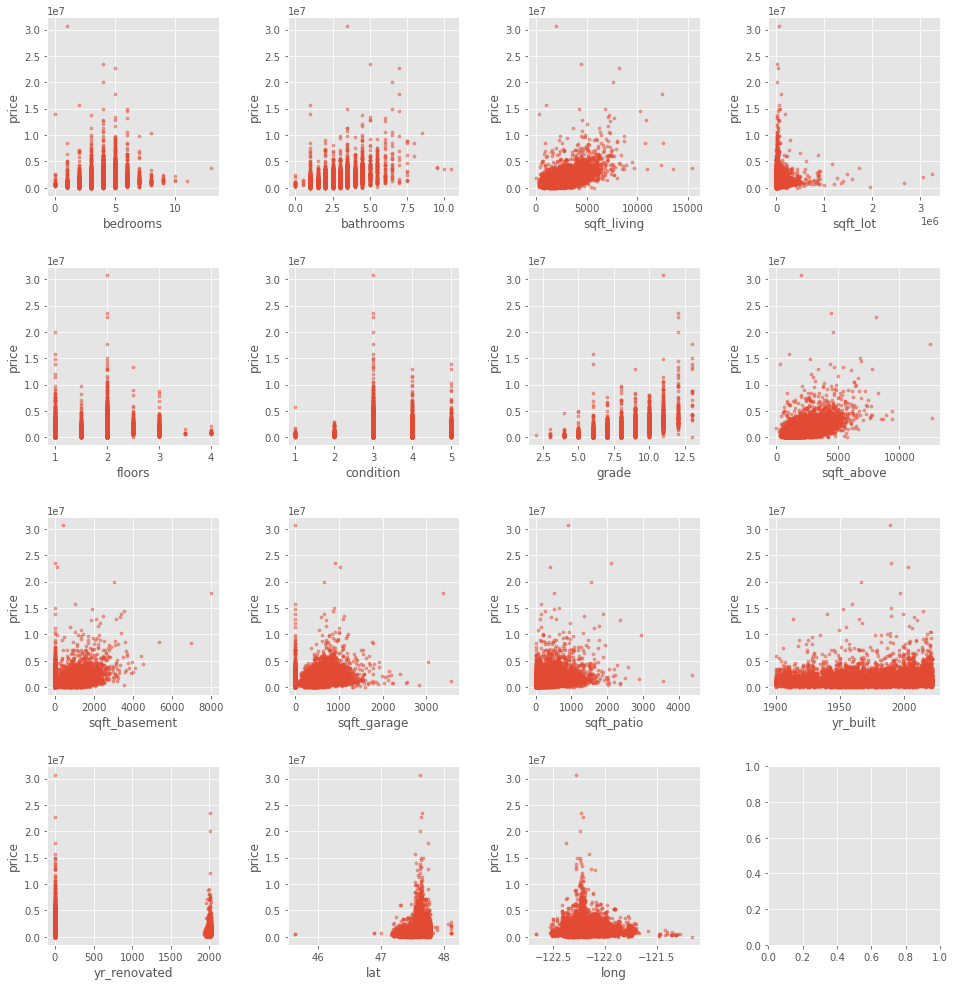

In [331]:
# Specify the dependent variable and independent variables
y_col = 'price'
x_cols = [col for col in df_numerical.columns if col != y_col][:15]  # Use the first 15 independent variables

# Create scatter plot matrix
fig, axs = plt.subplots(4, 4, figsize=(16, 16))
for i, x_var in enumerate(x_cols):
    row, col = divmod(i, 4)
    axs[row, col].scatter(df_numerical[x_var], df[y_col], alpha=0.5, s=10)
    axs[row, col].set_xlabel(x_var)
    axs[row, col].set_ylabel(y_col)

# Adjust plot layout
fig.subplots_adjust(top=0.93, hspace=0.4, wspace=0.4)

# Show the plot
plt.show()

### Extracting Categorical String Predictors

In [332]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29200 entries, 0 to 30154
Data columns (total 35 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   id                     29200 non-null  int64         
 1   date                   29200 non-null  datetime64[ns]
 2   price                  29200 non-null  float64       
 3   bedrooms               29200 non-null  int64         
 4   bathrooms              29200 non-null  float64       
 5   sqft_living            29200 non-null  int64         
 6   sqft_lot               29200 non-null  int64         
 7   floors                 29200 non-null  float64       
 8   waterfront             29200 non-null  object        
 9   greenbelt              29200 non-null  object        
 10  nuisance               29200 non-null  object        
 11  view                   29200 non-null  object        
 12  condition              29200 non-null  int64         
 13  g

In [333]:
categorical_types = ['O']
categorical_predictors = list(df.select_dtypes(include=categorical_types))
categorical_predictors

['waterfront',
 'greenbelt',
 'nuisance',
 'view',
 'heat_source',
 'sewer_system',
 'address',
 'zipcode',
 'waterfront_loc']

In [334]:
df_categorical = df[categorical_predictors]

In [335]:
df_categorical

,waterfront,greenbelt,nuisance,view,heat_source,sewer_system,address,zipcode,waterfront_loc
0,NO,NO,NO,NONE,Gas,PUBLIC,"2102 southeast 21st court, renton, washington ...",98055,other
1,NO,NO,YES,AVERAGE,Oil,PUBLIC,"11231 greenwood avenue north, seattle, washing...",98133,other
2,NO,NO,NO,AVERAGE,Gas,PUBLIC,"8504 south 113th street, seattle, washington 9...",98178,other
3,NO,NO,NO,AVERAGE,Gas,PUBLIC,"4079 letitia avenue south, seattle, washington...",98118,other
4,NO,NO,YES,NONE,Electricity,PUBLIC,"2193 northwest talus drive, issaquah, washingt...",98027,other
...,...,...,...,...,...,...,...,...,...
30150,NO,NO,NO,NONE,Oil,PUBLIC,"4673 eastern avenue north, seattle, washington...",98103,other
30151,NO,NO,NO,FAIR,Gas,PUBLIC,"4131 44th avenue southwest, seattle, washingto...",98116,other
30152,NO,NO,YES,NONE,Gas,PUBLIC,"910 martin luther king jr way, seattle, washin...",98122,other
30153,NO,NO,NO,NONE,Gas,PUBLIC,"17127 114th avenue southeast, renton, washingt...",98055,other


# Model #1

In [336]:
model_data = df_numerical

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.514
Model:                            OLS   Adj. R-squared:                  0.514
Method:                 Least Squares   F-statistic:                     1814.
Date:                Thu, 09 Mar 2023   Prob (F-statistic):               0.00
Time:                        20:30:28   Log-Likelihood:            -4.3109e+05
No. Observations:               29200   AIC:                         8.622e+05
Df Residuals:                   29182   BIC:                         8.624e+05
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          -6.16e+07      4e+06    -15.396

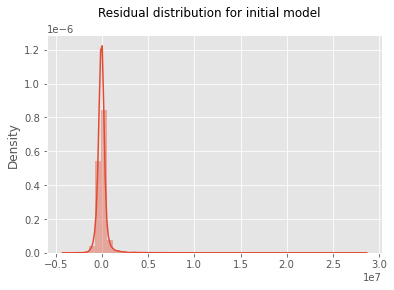

(None,
 Text(0.5, 0.98, 'Residual distribution for initial model'),
 <AxesSubplot:ylabel='Density'>,
 None)

In [337]:
get_OLS_model('initial',X = model_data, y = df['price'])

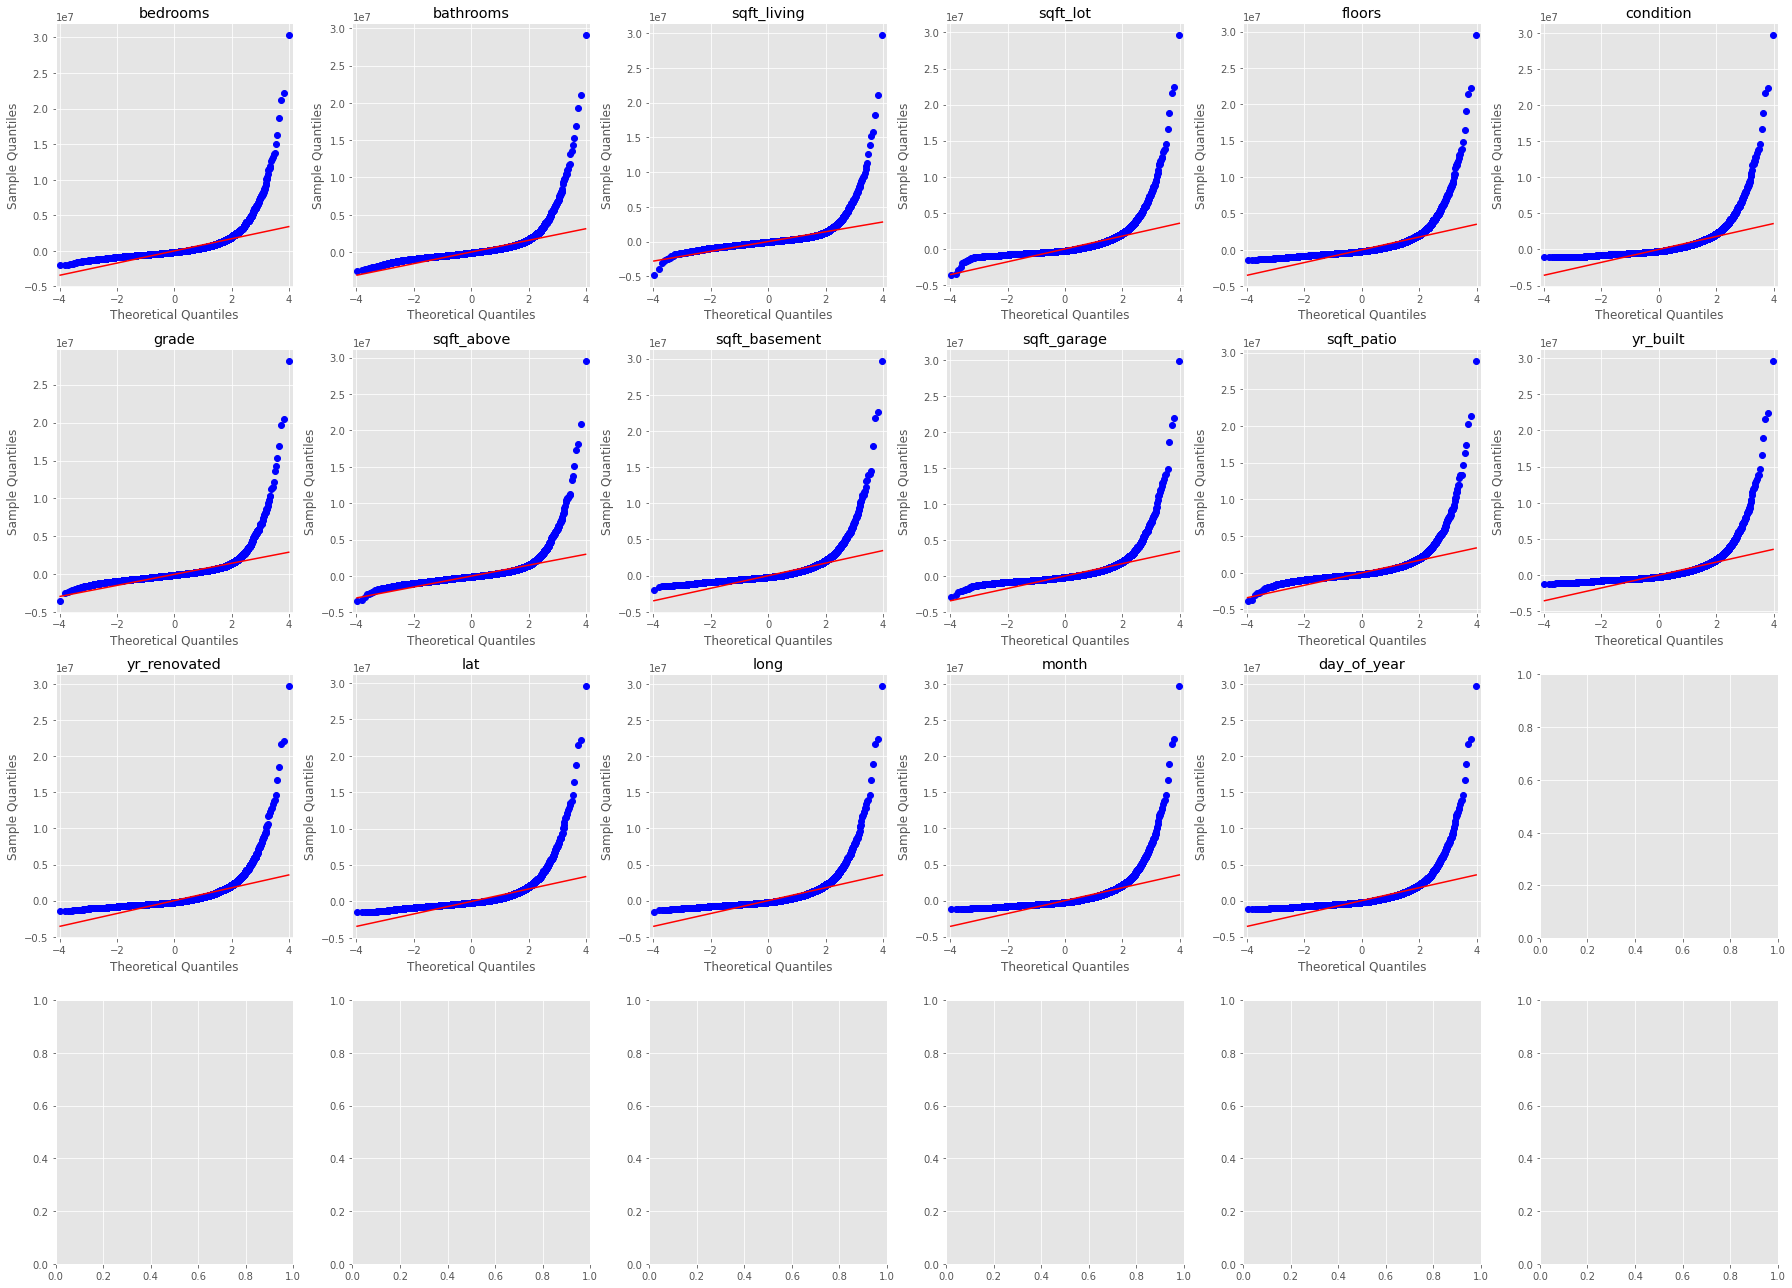

In [338]:
get_model_qqplots(model_data, df['price'])

# Observations

p_value > 0.05

- `longitude`**
- `month`

 - month was not anticipated as an effective predictor because it is not typical for the season to affect the sale price of a house
 
 Additional Observations:
 - The adjusted r-squared value is .514, indicating that his model can explain approximately 51.4% of the data.
 -  Skew: A kurtosis value between -2 and +2 is good to prove normalcy. The skew score is 10.065, indicating that this model is heavily skewed. This will be addressed through transformations to normalize the data. 

## Possible Improvements to be made to model:
    - dropping of variables that are not statistically significant (Pval > 0.05)
    - addition of categorial variables(one hot encoded)
    - location would possibly be the most interesting variable, mapped against the waterfront or view variable
    - transformation of data to satisfy normality assumption -ex: log transformation or square root transformation
    - removal of outliers: Outliers in this case will be considered to be any data falling greater than 
      3 standard deviations outside the mean
### Goals
    - improve skewness - removal of outliers
    - reduce homoscedacity - reduce value of VIFs
    - increase rsquared to promote higher level explanation of data from model

# Categorical data Exploratory Analysis and Engineering

The goal of this section will be to add in meaningful categorical data to the model, to be OneHotEncoded once prepped. For this, we first look at the categorical data. 

In [339]:
df_categorical.columns

Index(['waterfront', 'greenbelt', 'nuisance', 'view', 'heat_source',
       'sewer_system', 'address', 'zipcode', 'waterfront_loc'],
      dtype='object')

## Possible categorical variables of interest: 

* `waterfront` - Whether the house is on a waterfront
  * Includes Duwamish, Elliott Bay, Puget Sound, Lake Union, Ship Canal, Lake Washington, Lake Sammamish, other lake, and river/slough waterfronts
* `greenbelt` - Whether the house is adjacent to a green belt
* `nuisance` - Whether the house has traffic noise or other recorded nuisances
* `view` - Quality of view from house
  * Includes views of Mt. Rainier, Olympics, Cascades, Territorial, Seattle Skyline, Puget Sound, Lake Washington, Lake Sammamish, small lake / river / creek, and other
* `heat_source` - Heat source for the house
* `sewer_system` - Sewer system for the house
* `address` - The street address

The grade and condition are already onehotencoded in the model and could be changed to a numerical variable, so this part of the analysis will focus on the string categorical variables. 

The address appears to be the most interesting variable in the batch because it can be mapped against the waterfronts or the quality of view from the houses. For this, we will extrapolate features of the address to reduce and categorize the location. 

In [340]:
df['waterfront'].unique()

array(['NO', 'YES'], dtype=object)

In [341]:
# convert waterfront into numeric boolean
waterfront_bool_dict = {'YES':1,'NO':0,np.nan:0}
df_categorical.waterfront.replace(to_replace=waterfront_bool_dict,inplace=True)

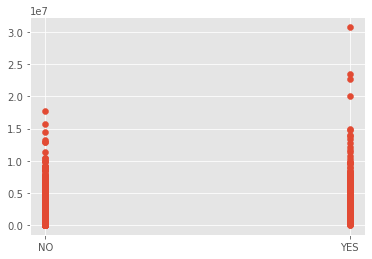

In [342]:
plt.scatter(x=df['waterfront'], y=df['price'])

In [343]:
df['nuisance'].unique()

array(['NO', 'YES'], dtype=object)

In [344]:
# convert nuisance into numeric boolean
nuisance_bool_dict = {'YES':1,'NO':0,np.nan:0}
df_categorical.nuisance.replace(to_replace=nuisance_bool_dict,inplace=True)

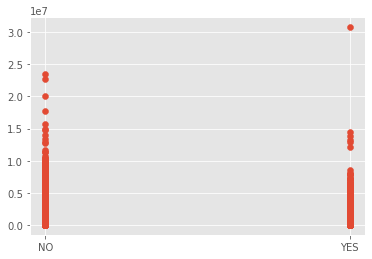

In [345]:
plt.scatter(x=df['nuisance'], y=df['price'])

In [346]:
# convert nuisance into numeric boolean
greenbelt_bool_dict = {'YES':1,'NO':0,np.nan:0}
df_categorical.greenbelt.replace(to_replace=greenbelt_bool_dict,inplace=True)

In [347]:
df['view'].unique()

array(['NONE', 'AVERAGE', 'EXCELLENT', 'FAIR', 'GOOD'], dtype=object)

In [348]:
# convert view from string into categorical ordinal
view_dict = {'NONE':0,'FAIR':1,'AVERAGE':2,'GOOD':3,'EXCELLENT':4}
df_categorical.view.replace(to_replace=view_dict,inplace=True)

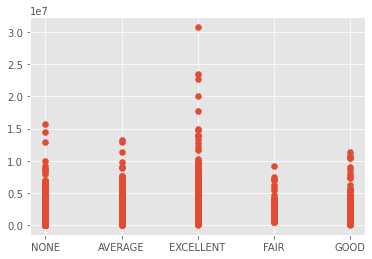

In [349]:
plt.scatter(x=df['view'], y=df['price'])

In [350]:
df['heat_source'].unique()

array(['Gas', 'Oil', 'Electricity', 'Gas/Solar', 'Electricity/Solar',
       'Other', 'Oil/Solar'], dtype=object)

In [351]:
heat_source_dummies = pd.get_dummies(df['heat_source'], prefix='heat_source',drop_first=True)
heat_source_dummies

,heat_source_Electricity/Solar,heat_source_Gas,heat_source_Gas/Solar,heat_source_Oil,heat_source_Oil/Solar,heat_source_Other
0,0,1,0,0,0,0
1,0,0,0,1,0,0
2,0,1,0,0,0,0
3,0,1,0,0,0,0
4,0,0,0,0,0,0
...,...,...,...,...,...,...
30150,0,0,0,1,0,0
30151,0,1,0,0,0,0
30152,0,1,0,0,0,0
30153,0,1,0,0,0,0


In [352]:
df['sewer_system'].unique()

array(['PUBLIC', 'PRIVATE', 'PRIVATE RESTRICTED', 'PUBLIC RESTRICTED'],
      dtype=object)

In [353]:
sewer_dummies = pd.get_dummies(df['sewer_system'],prefix='sewer', drop_first=True)
sewer_dummies

,sewer_PRIVATE RESTRICTED,sewer_PUBLIC,sewer_PUBLIC RESTRICTED
0,0,1,0
1,0,1,0
2,0,1,0
3,0,1,0
4,0,1,0
...,...,...,...
30150,0,1,0
30151,0,1,0
30152,0,1,0
30153,0,1,0


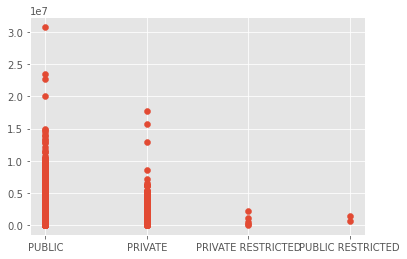

In [354]:
plt.scatter(x=df['sewer_system'], y=df['price'])

### Developing categorical dataframe

In [355]:
df_cat_pick = df_categorical[['waterfront','nuisance','view','greenbelt']]

## Model #2

In [356]:
model_2_data = pd.concat([df_numerical,sewer_dummies,heat_source_dummies, df_cat_pick], axis = 1)

In [357]:
len(model_2_data) == len(waterfront_dummies)

True

In [358]:
model_2_data.columns

Index(['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'condition', 'grade', 'sqft_above', 'sqft_basement', 'sqft_garage',
       'sqft_patio', 'yr_built', 'yr_renovated', 'lat', 'long', 'month',
       'day_of_year', 'sewer_PRIVATE RESTRICTED', 'sewer_PUBLIC',
       'sewer_PUBLIC RESTRICTED', 'heat_source_Electricity/Solar',
       'heat_source_Gas', 'heat_source_Gas/Solar', 'heat_source_Oil',
       'heat_source_Oil/Solar', 'heat_source_Other', 'waterfront', 'nuisance',
       'view', 'greenbelt'],
      dtype='object')

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.555
Model:                            OLS   Adj. R-squared:                  0.554
Method:                 Least Squares   F-statistic:                     1211.
Date:                Thu, 09 Mar 2023   Prob (F-statistic):               0.00
Time:                        20:30:50   Log-Likelihood:            -4.2981e+05
No. Observations:               29200   AIC:                         8.597e+05
Df Residuals:                   29169   BIC:                         8.599e+05
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

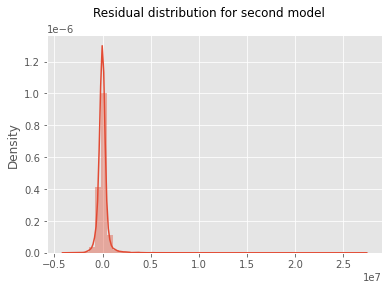

(None,
 Text(0.5, 0.98, 'Residual distribution for second model'),
 <AxesSubplot:ylabel='Density'>,
 None)

In [359]:
get_OLS_model('second',model_2_data, df['price'])

`heat_source`, `greenbelt` and `sewer_system` both have incredibly high p-values. These will be dropped from the final model if it holds. 

## Observations of Model 2

Model is still highly skewed although did present itself with some improvements. Next steps will be to normalize the data by transforming features that are skewed within the data, as well as remove outliers

- Jarque-Bera score is sky high and must come down for the model to hold any validity. 
- Durbin Watson score is in the acceptable range of 1.50-2.50
- Rsquared has 'improved' but only at the expense of the the continued flaws mentioned before. 

## Eliminating Outliers

To normalize the distribution, outlier removal will be the first step. An outlier will be defined as three standard deviations away from the mean of the target variable.

In [360]:
outlier_thresh = df['price'].std()*3 # value of the prices at the third standard deviation
df_outlier_removed = df.loc[abs(df['price']) <= outlier_thresh] # slicing all data within the defined range

# assign y as the target variable
y = df_outlier_removed['price']

In [361]:
model_2_data_outlier_removed = model_2_data.loc[abs(df['price']) <= outlier_thresh]

In [362]:
df_outlier_removed

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,greenbelt,...,zipcode,waterfront_loc,water_Elliot Bay,water_Lake Sammamish,water_Lake Union,water_Lake Washington,water_Puget Sound,water_other,month,day_of_year
0,7399300360,2022-05-24,675000.0,4,1.0,1180,7140,1.0,NO,NO,...,98055,other,0,0,0,0,0,1,5,144
1,8910500230,2021-12-13,920000.0,5,2.5,2770,6703,1.0,NO,NO,...,98133,other,0,0,0,0,0,1,12,347
2,1180000275,2021-09-29,311000.0,6,2.0,2880,6156,1.0,NO,NO,...,98178,other,0,0,0,0,0,1,9,272
3,1604601802,2021-12-14,775000.0,3,3.0,2160,1400,2.0,NO,NO,...,98118,other,0,0,0,0,0,1,12,348
4,8562780790,2021-08-24,592500.0,2,2.0,1120,758,2.0,NO,NO,...,98027,other,0,0,0,0,0,1,8,236
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30150,7834800180,2021-11-30,1555000.0,5,2.0,1910,4000,1.5,NO,NO,...,98103,other,0,0,0,0,0,1,11,334
30151,194000695,2021-06-16,1313000.0,3,2.0,2020,5800,2.0,NO,NO,...,98116,other,0,0,0,0,0,1,6,167
30152,7960100080,2022-05-27,800000.0,3,2.0,1620,3600,1.0,NO,NO,...,98122,other,0,0,0,0,0,1,5,147
30153,2781280080,2022-02-24,775000.0,3,2.5,2570,2889,2.0,NO,NO,...,98055,other,0,0,0,0,0,1,2,55


In [363]:
waterfront_dummies = df_outlier_removed[['water_Elliot Bay','water_Lake Sammamish', 'water_Lake Washington','water_Puget Sound','water_other']]

In [364]:
df_outlier_removed.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'greenbelt', 'nuisance', 'view',
       'condition', 'grade', 'heat_source', 'sewer_system', 'sqft_above',
       'sqft_basement', 'sqft_garage', 'sqft_patio', 'yr_built',
       'yr_renovated', 'address', 'lat', 'long', 'zipcode', 'waterfront_loc',
       'water_Elliot Bay', 'water_Lake Sammamish', 'water_Lake Union',
       'water_Lake Washington', 'water_Puget Sound', 'water_other', 'month',
       'day_of_year'],
      dtype='object')

## New look at model with removed outliers

In [365]:
outlier_data = pd.concat([y,model_2_data_outlier_removed], axis=1)

In [366]:
outlier_data = outlier_data.drop('price', axis=1)

In [367]:
len(outlier_data)

28004

In [368]:
outlier_data

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,grade,sqft_above,sqft_basement,sqft_garage,...,heat_source_Electricity/Solar,heat_source_Gas,heat_source_Gas/Solar,heat_source_Oil,heat_source_Oil/Solar,heat_source_Other,waterfront,nuisance,view,greenbelt
0,4,1.0,1180,7140,1.0,4,7,1180,0,0,...,0,1,0,0,0,0,0,0,0,0
1,5,2.5,2770,6703,1.0,3,7,1570,1570,0,...,0,0,0,1,0,0,0,1,2,0
2,6,2.0,2880,6156,1.0,3,7,1580,1580,0,...,0,1,0,0,0,0,0,0,2,0
3,3,3.0,2160,1400,2.0,3,9,1090,1070,200,...,0,1,0,0,0,0,0,0,2,0
4,2,2.0,1120,758,2.0,3,7,1120,550,550,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30150,5,2.0,1910,4000,1.5,4,8,1600,1130,0,...,0,0,0,1,0,0,0,0,0,0
30151,3,2.0,2020,5800,2.0,3,7,2020,0,0,...,0,1,0,0,0,0,0,0,1,0
30152,3,2.0,1620,3600,1.0,3,7,940,920,240,...,0,1,0,0,0,0,0,1,0,0
30153,3,2.5,2570,2889,2.0,3,8,1830,740,480,...,0,1,0,0,0,0,0,0,0,0


## Model #3

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.622
Model:                            OLS   Adj. R-squared:                  0.622
Method:                 Least Squares   F-statistic:                     1534.
Date:                Thu, 09 Mar 2023   Prob (F-statistic):               0.00
Time:                        20:30:59   Log-Likelihood:            -3.9347e+05
No. Observations:               28004   AIC:                         7.870e+05
Df Residuals:                   27973   BIC:                         7.873e+05
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

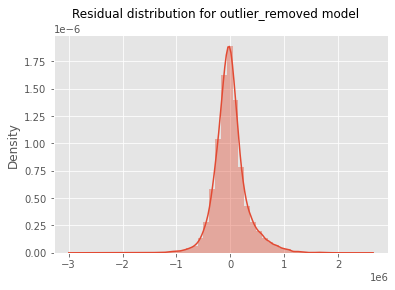

(None,
 Text(0.5, 0.98, 'Residual distribution for outlier_removed model'),
 <AxesSubplot:ylabel='Density'>,
 None)

In [369]:
get_OLS_model('outlier_removed', outlier_data,y)

In [370]:
outlier_data.columns

Index(['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'condition', 'grade', 'sqft_above', 'sqft_basement', 'sqft_garage',
       'sqft_patio', 'yr_built', 'yr_renovated', 'lat', 'long', 'month',
       'day_of_year', 'sewer_PRIVATE RESTRICTED', 'sewer_PUBLIC',
       'sewer_PUBLIC RESTRICTED', 'heat_source_Electricity/Solar',
       'heat_source_Gas', 'heat_source_Gas/Solar', 'heat_source_Oil',
       'heat_source_Oil/Solar', 'heat_source_Other', 'waterfront', 'nuisance',
       'view', 'greenbelt'],
      dtype='object')

## Observations of model 3
pvalue > 0.05
- `sqft_basement` 
- `sqft_garage`
- `sewer_PRIVATE RESTRICTED`
- `sewer_PUBLIC RESTRICTED`
- `heat_source_Electricity/Solar`
- `heat_source_Oil/Solar`
- `heat_source_Other`



- Adjusted rsquared indicates that the model explains 62.2% of the data.
- Skewness has improved dramatically to an acceptable range between -2 and 2. The removal of outliers has made this possible.
- Durbin-Watson score is still in the acceptable ranges of 1.5-2.5
- Jarque-Bera score is still very high but has been brought down by a significant factor. Still not perfect but trending in the right direction.
- Multicollinearity is possibly present in the model and likely so given the initial VIFs before the first model was built. VIFS should be revisited again to see if those variables are worth keeping. 

## Looking at transformations for the price.

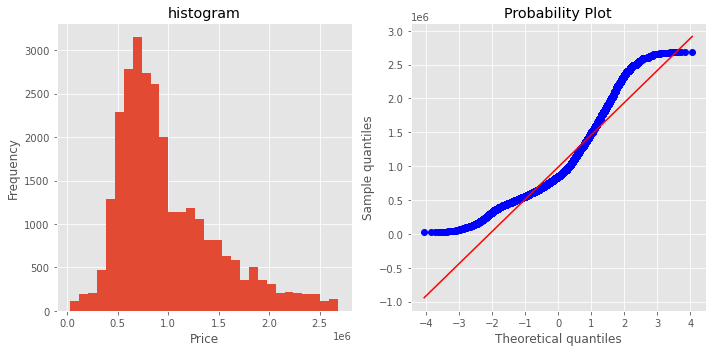

In [371]:
import scipy.stats as stats
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Plot histogram on the first subplot
axs[0].hist(y, bins=30)
axs[0].set_xlabel('Price')
axs[0].set_ylabel('Frequency')
axs[0].set_title('histogram')
# Plot QQ-plot on the second subplot
stats.probplot(y, plot=axs[1])
axs[1].set_xlabel('Theoretical quantiles')
axs[1].set_ylabel('Sample quantiles')

# Adjust the layout and display the plot
plt.tight_layout()
plt.show()

### Issue above is the data shows linearization everywhere but both tails of the data. Catching the lower tail will be the goal for the next test of transformation. For this, we will try a root transformation. 

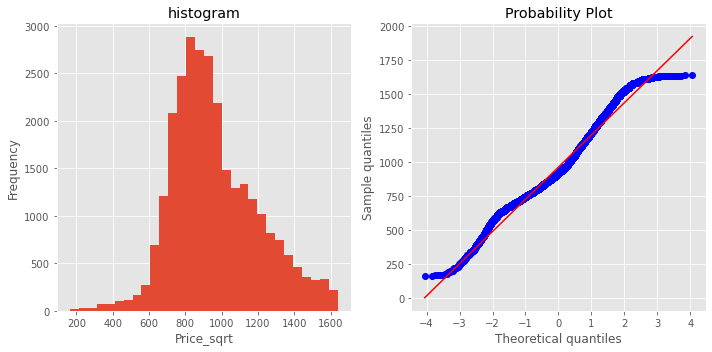

In [372]:
import matplotlib.pyplot as plt
import scipy.stats as stats

# Create subplots with 1 row and 2 columns
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
y_sqrt = y**0.5
# Plot histogram on the first subplot
axs[0].hist(y_sqrt, bins=30)
axs[0].set_xlabel('Price_sqrt')
axs[0].set_ylabel('Frequency')
axs[0].set_title('histogram')

# Plot QQ-plot on the second subplot
stats.probplot(y_sqrt, plot=axs[1])
axs[1].set_xlabel('Theoretical quantiles')
axs[1].set_ylabel('Sample quantiles')

# Adjust the layout and display the plot
plt.tight_layout()
plt.show()

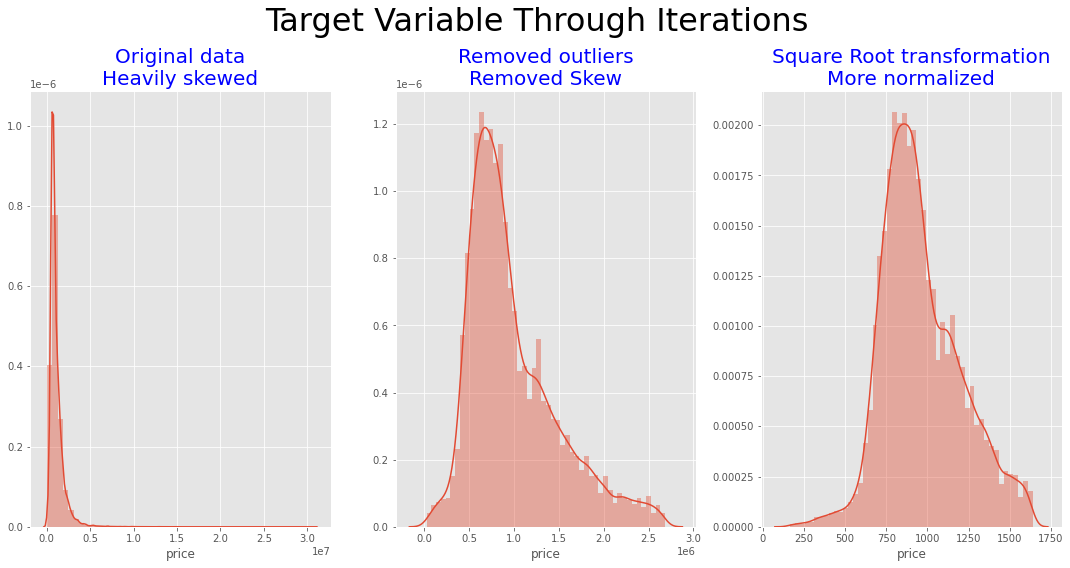

In [373]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3)

og = sns.distplot(df['price'],ax=ax1).set_title('Original data\nHeavily skewed',fontsize=20, color='b')
ot = sns.distplot(y,ax=ax2).set_title('Removed outliers\nRemoved Skew',fontsize=20, color='b')
lo = sns.distplot(y_sqrt,ax=ax3).set_title('Square Root transformation\nMore normalized',fontsize=20, color='b')

ax1.set_ylabel("")
ax2.set_ylabel("")
ax3.set_ylabel("")


plt.gcf().set_size_inches(15, 8)
plt.suptitle("Target Variable Through Iterations",fontsize=32)
fig.tight_layout()
plt.show()

### Checking model with transformed target variable - square root transformation

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.628
Model:                            OLS   Adj. R-squared:                  0.627
Method:                 Least Squares   F-statistic:                     1571.
Date:                Thu, 09 Mar 2023   Prob (F-statistic):               0.00
Time:                        20:31:08   Log-Likelihood:            -1.7940e+05
No. Observations:               28004   AIC:                         3.589e+05
Df Residuals:                   27973   BIC:                         3.591e+05
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

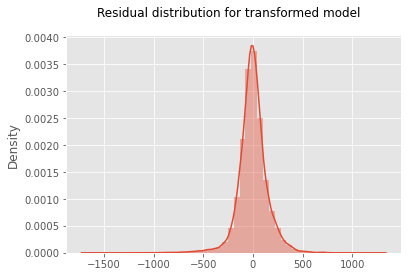

(None,
 Text(0.5, 0.98, 'Residual distribution for transformed model'),
 <AxesSubplot:ylabel='Density'>,
 None)

In [374]:
get_OLS_model('transformed', outlier_data, y_sqrt)

## y_log vs y_sqrt

The model with the square root transformation appears to be less skewed and possesses a higher rsquared value, lending the ability of the model to explain more of the data. For these reasons we will use y_sqrt as our dependent variable for now until y_log appears to outweight the benefit of y_sqrt.

Jarque-Beras score is significantly better as well with the y_sqrt variable so I'll go with it for now. 

In [375]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

X = outlier_data
# Fit a linear regression model
reg = LinearRegression().fit(X, y_sqrt)

# Predict the target values
y_pred = reg.predict(X)

# Calculate the mean absolute error
rmse = mean_squared_error(y_sqrt, y_pred)

print("Root mean squared error: ", rmse)

Root mean squared error:  21478.232538371158


## Checking distribution of predictor

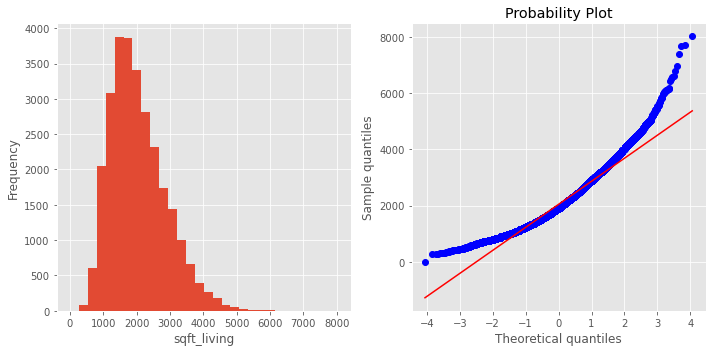

In [376]:
plot_hist_qq(outlier_data, 'sqft_living')

Data is clearly skewed right and follows an exponential pattern similar to price. For this, we will use a logarithmic transformation.

In [377]:
outlier_data['sqft_living_log'] = np.log(outlier_data['sqft_living']) 

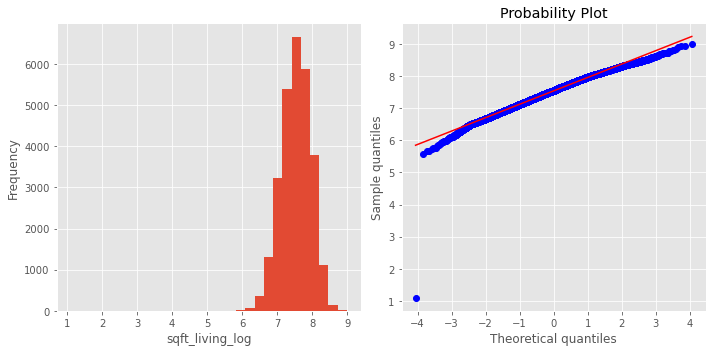

In [378]:
plot_hist_qq(outlier_data, 'sqft_living_log')

In [379]:
outlier_data = outlier_data.drop('sqft_living', axis=1)

In [380]:
outlier_data

,bedrooms,bathrooms,sqft_lot,floors,condition,grade,sqft_above,sqft_basement,sqft_garage,sqft_patio,...,heat_source_Gas,heat_source_Gas/Solar,heat_source_Oil,heat_source_Oil/Solar,heat_source_Other,waterfront,nuisance,view,greenbelt,sqft_living_log
0,4,1.0,7140,1.0,4,7,1180,0,0,40,...,1,0,0,0,0,0,0,0,0,7.073270
1,5,2.5,6703,1.0,3,7,1570,1570,0,240,...,0,0,1,0,0,0,1,2,0,7.926603
2,6,2.0,6156,1.0,3,7,1580,1580,0,0,...,1,0,0,0,0,0,0,2,0,7.965546
3,3,3.0,1400,2.0,3,9,1090,1070,200,270,...,1,0,0,0,0,0,0,2,0,7.677864
4,2,2.0,758,2.0,3,7,1120,550,550,30,...,0,0,0,0,0,0,1,0,0,7.021084
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30150,5,2.0,4000,1.5,4,8,1600,1130,0,210,...,0,0,1,0,0,0,0,0,0,7.554859
30151,3,2.0,5800,2.0,3,7,2020,0,0,520,...,1,0,0,0,0,0,0,1,0,7.610853
30152,3,2.0,3600,1.0,3,7,940,920,240,110,...,1,0,0,0,0,0,1,0,0,7.390181
30153,3,2.5,2889,2.0,3,8,1830,740,480,100,...,1,0,0,0,0,0,0,0,0,7.851661


                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.626
Model:                            OLS   Adj. R-squared:                  0.625
Method:                 Least Squares   F-statistic:                     1558.
Date:                Thu, 09 Mar 2023   Prob (F-statistic):               0.00
Time:                        20:31:17   Log-Likelihood:            -1.7948e+05
No. Observations:               28004   AIC:                         3.590e+05
Df Residuals:                   27973   BIC:                         3.593e+05
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

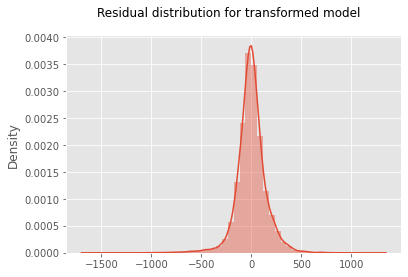

(None,
 Text(0.5, 0.98, 'Residual distribution for transformed model'),
 <AxesSubplot:ylabel='Density'>,
 None)

In [381]:
get_OLS_model('transformed', outlier_data, y_sqrt)

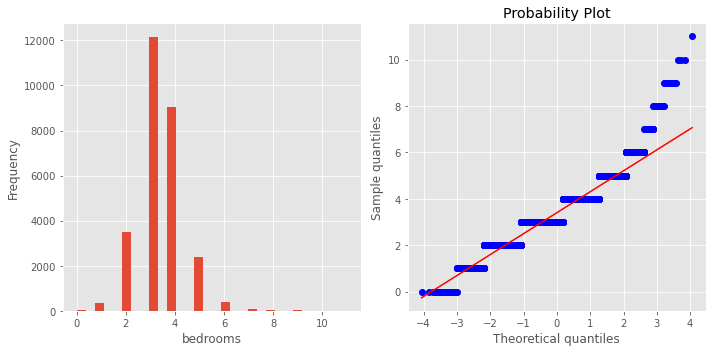

In [382]:
plot_hist_qq(outlier_data, 'bedrooms')

pval > 0.05

- `bedrooms` - will be dropped from the current model


In [383]:
outlier_data = outlier_data.drop(['bedrooms'], axis=1)

#### Rerun model

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.626
Model:                            OLS   Adj. R-squared:                  0.625
Method:                 Least Squares   F-statistic:                     1612.
Date:                Thu, 09 Mar 2023   Prob (F-statistic):               0.00
Time:                        20:31:25   Log-Likelihood:            -1.7948e+05
No. Observations:               28004   AIC:                         3.590e+05
Df Residuals:                   27974   BIC:                         3.593e+05
Df Model:                          29                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

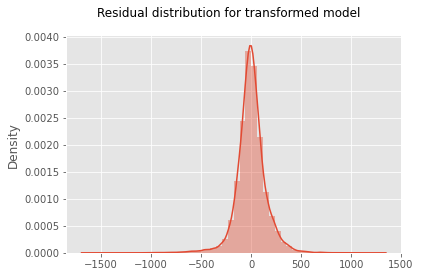

(None,
 Text(0.5, 0.98, 'Residual distribution for transformed model'),
 <AxesSubplot:ylabel='Density'>,
 None)

In [384]:
get_OLS_model('transformed', outlier_data, y_sqrt)

### Dropping sewer/heat source data

In [385]:
new_outlier_data = outlier_data.drop(['sewer_PRIVATE RESTRICTED','sewer_PUBLIC RESTRICTED', 'heat_source_Oil', 'heat_source_Oil/Solar', 'heat_source_Other', 'heat_source_Electricity/Solar'], axis =1)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.626
Model:                            OLS   Adj. R-squared:                  0.625
Method:                 Least Squares   F-statistic:                     2032.
Date:                Thu, 09 Mar 2023   Prob (F-statistic):               0.00
Time:                        20:31:28   Log-Likelihood:            -1.7948e+05
No. Observations:               28004   AIC:                         3.590e+05
Df Residuals:                   27980   BIC:                         3.592e+05
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                 -1.482e+

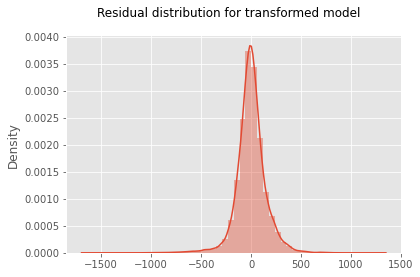

(None,
 Text(0.5, 0.98, 'Residual distribution for transformed model'),
 <AxesSubplot:ylabel='Density'>,
 None)

In [386]:
get_OLS_model('transformed', new_outlier_data, y_sqrt)

## Observations

- pval > 0.05

`bedrooms` - dropped from the current model

- all variables are statistically significant (pvalue < 0.05)
- Durbin-Watson Score continues to be "fine" but not improve a whole lot.
- Jarque-Bera Score continues to improve but still must come down
- skewness is now an afterthought as its at a very low -0.347
Overall no real improvement of the model happens here, we will try adding in new variables to improve as well as revisit VIFs to likely drop all that were originally at extremely high levels. 


Next steps to improve the model:
1. revisit VIFs to see if any variables(now that outliers are removed and data has been transformed) should now be dropped from the model. 
2. New predictors will be engineered to be added to the model. The next focus will be on the zipcodes in an attempt to narrow down the data with location-dependent price points. Possible data to be looked at are:
- waterfronts 
- views
- school districts: rating, and school taxes
- tax brackets



Jarque-Beras score and skew level continue to improve but there is still some work to do. 

In [387]:
X = new_outlier_data
# Fit a linear regression model
reg = LinearRegression().fit(X, y_sqrt)

# Predict the target values
y_pred = reg.predict(X)

# Calculate the mean absolute error
rmse = mean_squared_error(y_sqrt, y_pred)

print("Root mean squared error: ", rmse)

Root mean squared error:  21598.900418299952


## Rechecking VIFs

In [388]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Load your data into a pandas DataFrame
data = new_outlier_data

# Get a list of the column names
cols = data.columns

# Create an empty DataFrame to hold the VIF results
vif_data = pd.DataFrame()

# Loop through each column and calculate the VIF
for i in range(len(cols)):
    vif = variance_inflation_factor(data[cols].values, i)
    vif_data = vif_data.append({'Variable': cols[i], 'VIF': vif}, ignore_index=True)

# Print the VIF results
print(vif_data)

                 Variable            VIF
0               bathrooms      24.288806
1                sqft_lot       1.299694
2                  floors      17.333161
3               condition      31.675256
4                   grade     137.636761
5              sqft_above      48.182791
6           sqft_basement       4.898542
7             sqft_garage       4.593212
8              sqft_patio       2.242563
9                yr_built    9589.111873
10           yr_renovated       1.205507
11                    lat  109063.702426
12                   long  123718.741939
13                  month     698.983641
14            day_of_year     614.160609
15           sewer_PUBLIC       8.786042
16        heat_source_Gas       3.862553
17  heat_source_Gas/Solar       1.015119
18             waterfront       1.202680
19               nuisance       1.268623
20                   view       1.425702
21              greenbelt       1.061871
22        sqft_living_log    2675.580945


## Scaling data

In [389]:
scaledX = (new_outlier_data - np.mean(new_outlier_data)) / np.std(new_outlier_data)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.626
Model:                            OLS   Adj. R-squared:                  0.625
Method:                 Least Squares   F-statistic:                     2032.
Date:                Thu, 09 Mar 2023   Prob (F-statistic):               0.00
Time:                        20:31:40   Log-Likelihood:            -1.7948e+05
No. Observations:               28004   AIC:                         3.590e+05
Df Residuals:                   27980   BIC:                         3.592e+05
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                   963.82

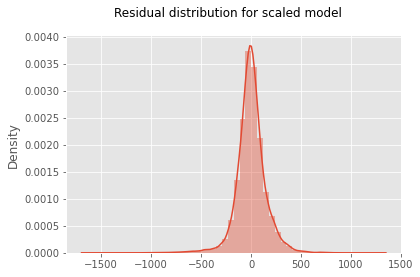

(None,
 Text(0.5, 0.98, 'Residual distribution for scaled model'),
 <AxesSubplot:ylabel='Density'>,
 None)

In [390]:
get_OLS_model('scaled',scaledX, y_sqrt)

### Adding waterfront dummies to the model

In [391]:
water_data = pd.concat([scaledX,waterfront_dummies], axis=1)

In [392]:
water_data.columns

Index(['bathrooms', 'sqft_lot', 'floors', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'sqft_garage', 'sqft_patio', 'yr_built',
       'yr_renovated', 'lat', 'long', 'month', 'day_of_year', 'sewer_PUBLIC',
       'heat_source_Gas', 'heat_source_Gas/Solar', 'waterfront', 'nuisance',
       'view', 'greenbelt', 'sqft_living_log', 'water_Elliot Bay',
       'water_Lake Sammamish', 'water_Lake Washington', 'water_Puget Sound',
       'water_other'],
      dtype='object')

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.634
Model:                            OLS   Adj. R-squared:                  0.634
Method:                 Least Squares   F-statistic:                     1732.
Date:                Thu, 09 Mar 2023   Prob (F-statistic):               0.00
Time:                        20:31:43   Log-Likelihood:            -1.7916e+05
No. Observations:               28004   AIC:                         3.584e+05
Df Residuals:                   27975   BIC:                         3.586e+05
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                   927.75

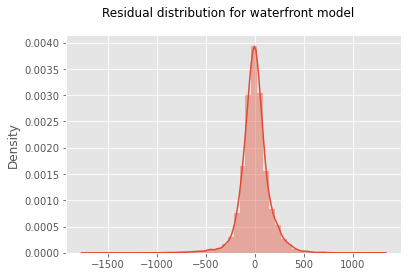

(None,
 Text(0.5, 0.98, 'Residual distribution for waterfront model'),
 <AxesSubplot:ylabel='Density'>,
 None)

In [393]:
get_OLS_model('waterfront',water_data,y_sqrt)

Elliot Bay and Puget Sound present high pvalues indicating a lack of statistical significance. These will be dropped from the model. 

In [394]:
water_data = water_data.drop(['water_Elliot Bay','water_Puget Sound'], axis=1)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.634
Model:                            OLS   Adj. R-squared:                  0.634
Method:                 Least Squares   F-statistic:                     1865.
Date:                Thu, 09 Mar 2023   Prob (F-statistic):               0.00
Time:                        20:31:45   Log-Likelihood:            -1.7916e+05
No. Observations:               28004   AIC:                         3.584e+05
Df Residuals:                   27977   BIC:                         3.586e+05
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                   930.13

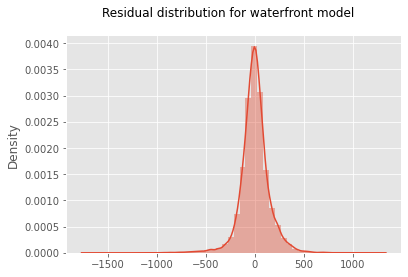

(None,
 Text(0.5, 0.98, 'Residual distribution for waterfront model'),
 <AxesSubplot:ylabel='Density'>,
 None)

In [395]:
get_OLS_model('waterfront',water_data,y_sqrt)

## Recheck VIFs

In [396]:
get_vifs(water_data)

                 Variable         VIF
0               bathrooms    2.822139
1                sqft_lot    1.207074
2                  floors    2.095512
3               condition    1.266178
4                   grade    2.708837
5              sqft_above    7.942106
6           sqft_basement    2.955381
7             sqft_garage    1.950322
8              sqft_patio    1.259318
9                yr_built    2.769200
10           yr_renovated    1.158303
11                    lat    1.311024
12                   long    1.646079
13                  month  117.635393
14            day_of_year  117.622422
15           sewer_PUBLIC    1.494553
16        heat_source_Gas    1.235084
17  heat_source_Gas/Solar    1.012087
18             waterfront    1.189363
19               nuisance    1.056349
20                   view    1.288746
21              greenbelt    1.045751
22        sqft_living_log    8.326010
23   water_Lake Sammamish    1.133347
24  water_Lake Washington    1.160076
25          

#### Month and day_of_year present with high variance inflation factors indicating possible collinearity. These will be dropped. 

In [397]:
water_data = water_data.drop(['month','day_of_year'], axis =1)

In [398]:
get_vifs(water_data)

                 Variable       VIF
0               bathrooms  2.820882
1                sqft_lot  1.206917
2                  floors  2.095106
3               condition  1.265521
4                   grade  2.708681
5              sqft_above  7.941105
6           sqft_basement  2.955260
7             sqft_garage  1.949919
8              sqft_patio  1.259183
9                yr_built  2.767781
10           yr_renovated  1.158123
11                    lat  1.311003
12                   long  1.645893
13           sewer_PUBLIC  1.494486
14        heat_source_Gas  1.235073
15  heat_source_Gas/Solar  1.012068
16             waterfront  1.189304
17               nuisance  1.056119
18                   view  1.288704
19              greenbelt  1.045747
20        sqft_living_log  8.325701
21   water_Lake Sammamish  1.133158
22  water_Lake Washington  1.159873
23            water_other  1.007988


All VIFs are now below 10 with the majority less than 3, meaning the issue of collinearity is now for the most part solved. 

## Final model

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.626
Model:                            OLS   Adj. R-squared:                  0.625
Method:                 Least Squares   F-statistic:                     1949.
Date:                Thu, 09 Mar 2023   Prob (F-statistic):               0.00
Time:                        20:31:59   Log-Likelihood:            -1.7948e+05
No. Observations:               28004   AIC:                         3.590e+05
Df Residuals:                   27979   BIC:                         3.592e+05
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                   929.17

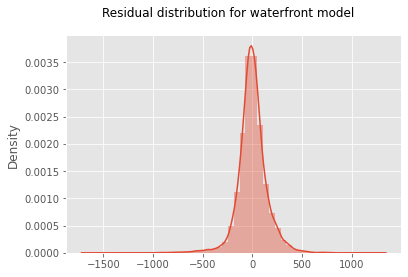

(None,
 Text(0.5, 0.98, 'Residual distribution for waterfront model'),
 <AxesSubplot:ylabel='Density'>,
 None)

In [399]:
get_OLS_model('waterfront',water_data,y_sqrt)

In [400]:
water_data.columns

Index(['bathrooms', 'sqft_lot', 'floors', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'sqft_garage', 'sqft_patio', 'yr_built',
       'yr_renovated', 'lat', 'long', 'sewer_PUBLIC', 'heat_source_Gas',
       'heat_source_Gas/Solar', 'waterfront', 'nuisance', 'view', 'greenbelt',
       'sqft_living_log', 'water_Lake Sammamish', 'water_Lake Washington',
       'water_other'],
      dtype='object')

## Constructing QQplots for all independent variables within the model

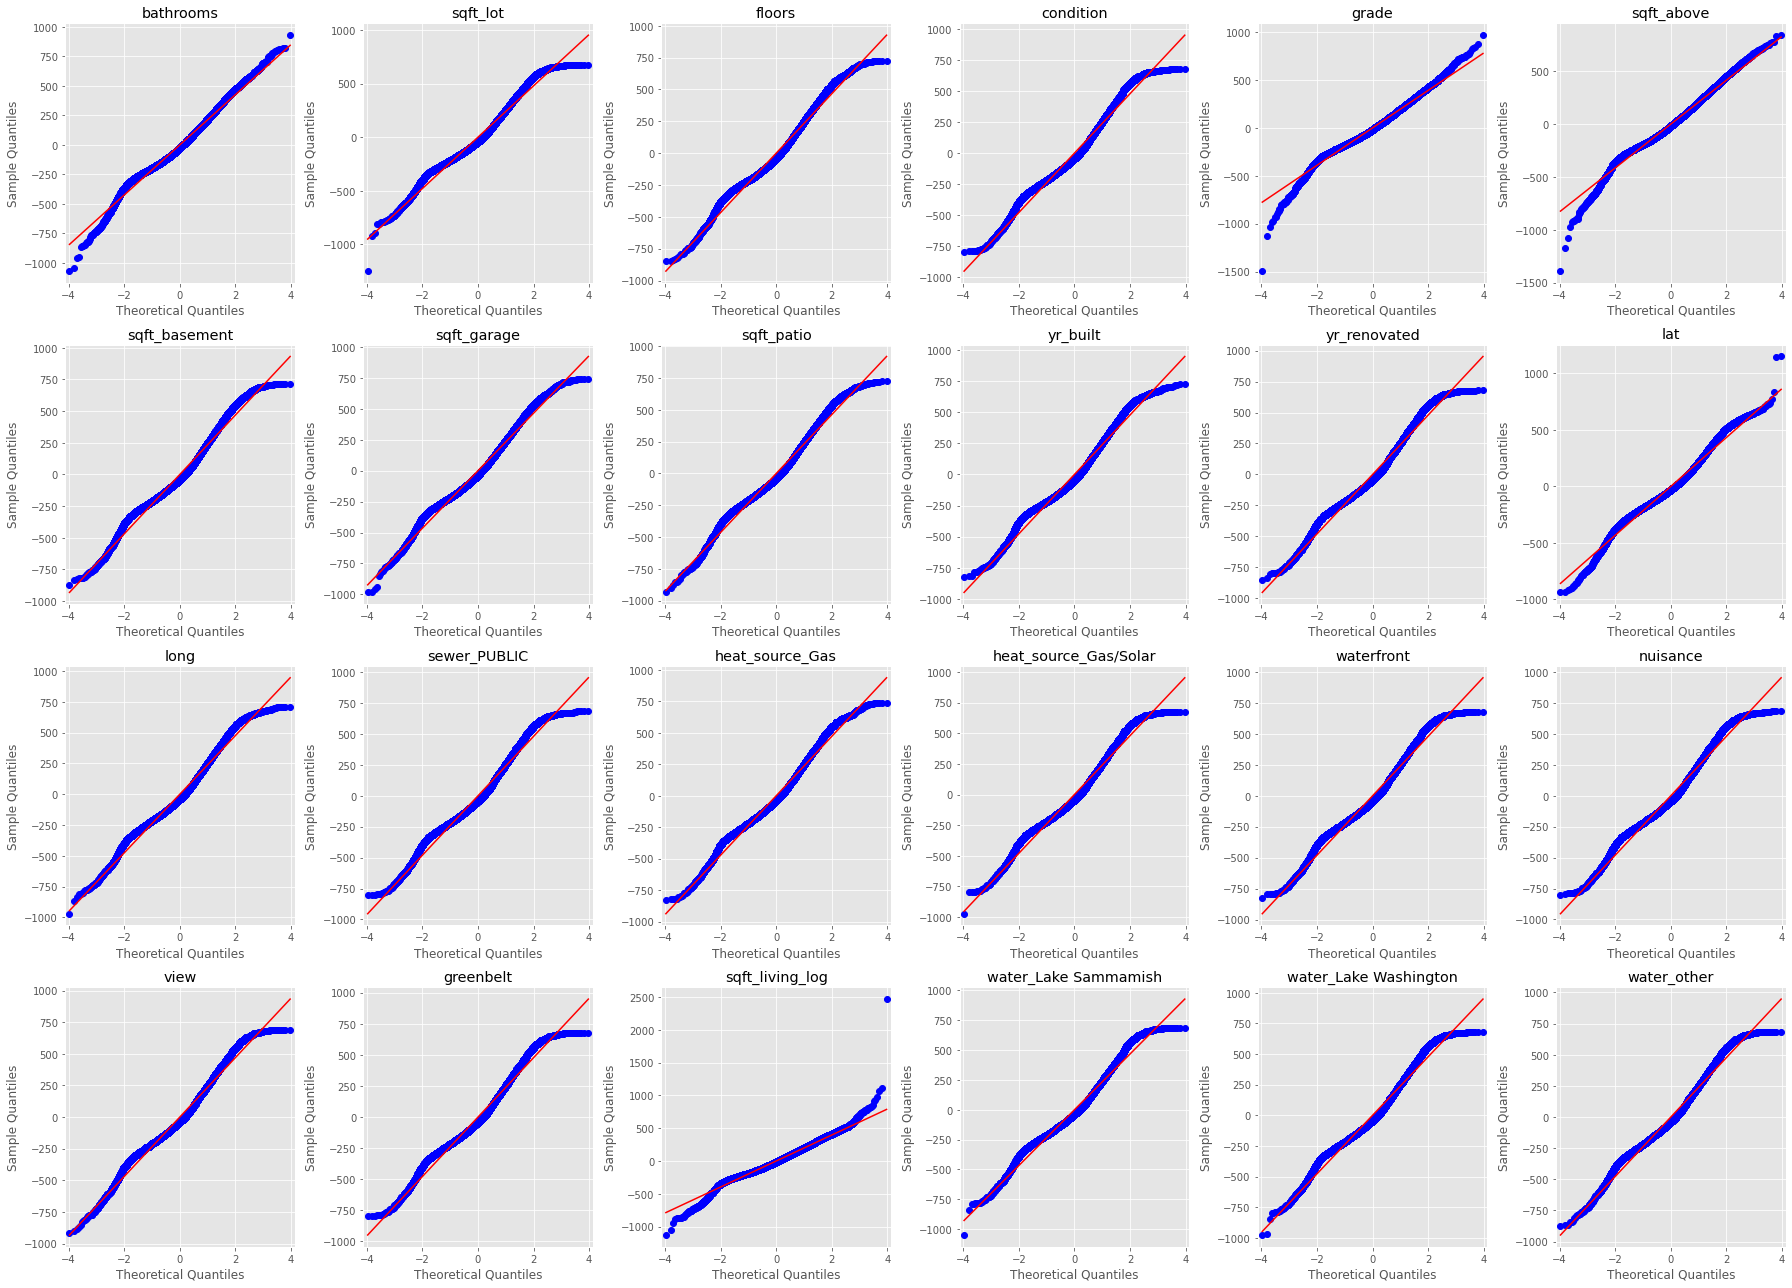

In [401]:
get_model_qqplots(water_data, y_sqrt)

In [271]:
model = sm.OLS(y_sqrt, sm.add_constant(water_data))
results = model.fit()
model_residual = results.resid
model_params = results.params

print(results.params)

const                    929.176743
bathrooms                 17.832111
sqft_lot                  10.776486
floors                    -5.769272
condition                 23.438047
grade                     69.763857
sqft_above                63.905587
sqft_basement             17.451898
sqft_garage               -3.105150
sqft_patio                 7.790561
yr_built                 -26.362631
yr_renovated               6.568336
lat                      100.368386
long                      11.706009
sewer_PUBLIC               5.427152
heat_source_Gas            9.342830
heat_source_Gas/Solar      3.547675
waterfront                 7.009294
nuisance                  -5.658225
view                      23.057945
greenbelt                  7.569852
sqft_living_log           15.177339
water_Lake Sammamish     137.741862
water_Lake Washington    -22.604616
water_other               34.141607
dtype: float64


We have a linear model with the dependent variable (price) square root transformed, and the following independent variables and their corresponding coefficients:

- Bathrooms: 17.832111
- Sqft_lot: 10.776486
- Floors: -5.769272
- Condition: 23.438047
- Grade: 69.763857
- Sqft_above: 63.905587
- Sqft_basement: 17.451898
- Sqft_garage: -3.105150
- Sqft_patio: 7.790561
- Yr_built: -26.362631
- Yr_renovated: 6.568336
- Lat: 100.368386
- Long: 11.706009
- Sewer_PUBLIC: 5.427152
- Heat_source_Gas: 9.342830
- Heat_source_Gas/Solar: 3.547675
- Waterfront: 7.009294
- Nuisance: -5.658225
- View: 23.057945
- Greenbelt: 7.569852
- Sqft_living_log: 15.177339
- Water_Lake Sammamish: 137.741862
- Water_Lake Washington: -22.604616
- Water_other: 34.141607


`A positive coefficient indicates that as the corresponding independent variable increases, the square root of the price of the house also increases, while a negative coefficient indicates that as the corresponding independent variable increases, the square root of the price of the house decreases.`

`In this model, we see that the most important variable in predicting the square root of house prices is the latitude of the house, with a coefficient of 100.368386. This suggests that houses located further north tend to have higher prices. The next most important variable is water proximity, with Water_Lake Sammamish variable having a very high coefficient of 137.741862, suggesting that houses located near this lake tend to have much higher prices than other houses. On the other hand, the Water_Lake Washington variable has a negative coefficient, indicating that houses located near this lake tend to have lower prices than other houses.`

`Other important variables include the grade of the house, the square footage of the house above ground, and the condition of the house, all with coefficients greater than 20. The number of bathrooms, square footage of the basement, and the size of the view from the house are also important, with coefficients greater than 15.`

`On the other hand, variables such as the square footage of the garage and the presence of a nuisance nearby have negative coefficients, indicating that houses with larger garages or located near nuisances tend to have lower prices. The year the house was built and the longitude of the house also have negative coefficients, suggesting that older houses and houses located further west tend to have lower prices.`

`Overall, these results suggest that there are many factors that contribute to the price of a house, and that location, house size and quality, and the presence of nearby amenities all play important roles in determining the square root of house prices.`